In [1]:
# import things
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import cv2
import numpy as np
import os
import glob
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from focal_loss import BinaryFocalLoss
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



2025-01-21 12:42:03.844729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 12:42:03.844777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 12:42:03.846042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 12:42:03.852913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
patch_size = 256
patch_dir = '256_dataset'

In [3]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

cb = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

In [4]:
# Define U-Net

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
    model.summary()
    
    return model

In [ ]:
# Build U-Net
model = simple_unet_model(patch_size, patch_size, 1)


2025-01-21 12:42:05.969734: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-21 12:42:05.970149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45645 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

def natural_sort(file_list):
    """Sort file list numerically based on numbers in filenames."""
    import re
    return sorted(file_list, key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])

class ImageMaskGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, target_size, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        # Get sorted filenames
        self.image_filenames = natural_sort([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_filenames = natural_sort([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

        assert len(self.image_filenames) == len(self.mask_filenames), \
            "Mismatch in number of images and masks."
        
        self.indexes = np.arange(len(self.image_filenames))
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = self.__data_generation(batch_indexes)
        return images, masks

    def __data_generation(self, batch_indexes):
        """Generate data for the batch."""
        images = np.empty((self.batch_size, *self.target_size, 1))
        masks = np.empty((self.batch_size, *self.target_size, 1))

        for i, idx in enumerate(batch_indexes):
            image_path = os.path.join(self.image_dir, self.image_filenames[idx])
            mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

            # Load and preprocess image and mask
            image = img_to_array(load_img(image_path, target_size=self.target_size, color_mode='grayscale'))
            mask = img_to_array(load_img(mask_path, target_size=self.target_size, color_mode='grayscale'))

            # Apply random contrast and brightness adjustments
            image = self.__apply_random_contrast(image)
            image = self.__apply_random_brightness(image)

            images[i, ...] = image / 255.0  # Normalize to 0-1
            masks[i, ...] = mask  # Masks remain unchanged

        return images, masks

    def __apply_random_contrast(self, image):
        """Apply random contrast adjustment."""
        contrast_factor = np.random.uniform(0.8, 1.2)  # Random factor between 0.8 and 1.2
        return tf.image.adjust_contrast(image, contrast_factor)

    def __apply_random_brightness(self, image):
        """Apply random brightness adjustment."""
        brightness_delta = np.random.uniform(-0.2, 0.2)  # Random delta between -0.2 and 0.2
        return tf.image.adjust_brightness(image, brightness_delta)

In [7]:
# batch size
batch_size = 32

# Directories
patch_dir = "256_dataset"


In [8]:
# Setup a generator for training

train_image_dir = os.path.join(patch_dir, 'train_images/train')
train_mask_dir = os.path.join(patch_dir, 'train_masks/train')

# Generator Parameters
patch_size_2 = (256, 256)

# Initialize Generators
train_generator = ImageMaskGenerator(train_image_dir, train_mask_dir, batch_size, patch_size_2)

# Count the number of images
num_train_images = len(train_generator.image_filenames)
num_classes = 1  # Binary masks

# Print the output
print(f"Found {num_train_images} images belonging to {num_classes} classes.")



Found 32167 images belonging to 1 classes.


In [9]:
# Setup a generator for validation

val_image_dir = os.path.join(patch_dir, 'val_images/val')
val_mask_dir = os.path.join(patch_dir, 'val_masks/val')

# Generator Parameters

# Initialize Generators
val_generator = ImageMaskGenerator(val_image_dir, val_mask_dir, batch_size, patch_size_2)


# Count the number of images
num_val_images = len(val_generator.image_filenames)

# Print the output
print(f"Found {num_train_images} images belonging to {num_classes} classes.")


Found 32167 images belonging to 1 classes.


In [10]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
cb = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# Run model training
history = model.fit(
    train_generator,  # Use the custom train generator
    steps_per_epoch=len(train_generator),  # Number of training batches
    epochs=25,
    validation_data=val_generator,  # Use the custom validation generator
    validation_steps=len(val_generator)//batch_size,  # Number of validation batches
    callbacks=[cb]
)


Epoch 1/25


2025-01-21 12:42:10.478113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-21 12:42:11.023268: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-21 12:42:13.524650: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f86904931b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-21 12:42:13.524682: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-21 12:42:13.530968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737463333.659999   53053 device_compiler.h:186] Compiled cluster using XLA!  This lin

1005/1005 [==============================] - 225s 205ms/step - loss: 0.0713 - f1: 2.7926e-05 - val_loss: 0.0462 - val_f1: 0.0000e+00
Epoch 2/25
1005/1005 [==============================] - 190s 189ms/step - loss: 0.0670 - f1: 8.0575e-06 - val_loss: 0.0299 - val_f1: 4.3654e-04
Epoch 3/25
1005/1005 [==============================] - 189s 188ms/step - loss: 0.0687 - f1: 0.0261 - val_loss: 0.0284 - val_f1: 0.0000e+00
Epoch 4/25
1005/1005 [==============================] - 197s 196ms/step - loss: 0.0650 - f1: 0.0000e+00 - val_loss: 0.0301 - val_f1: 0.0000e+00
Epoch 5/25
1005/1005 [==============================] - 196s 195ms/step - loss: 0.0596 - f1: 0.1496 - val_loss: 0.0266 - val_f1: 0.5917
Epoch 6/25
1005/1005 [==============================] - 193s 192ms/step - loss: 0.0536 - f1: 0.5160 - val_loss: 0.0199 - val_f1: 0.5700
Epoch 7/25
1005/1005 [==============================] - 192s 191ms/step - loss: 0.0517 - f1: 0.5724 - val_loss: 0.0084 - val_f1: 0.7080
Epoch 8/25
1005/1005 [=========

In [ ]:
# print(example_file_name)
# model.save(example_file_name)

rafal_234778_unet_model_256px.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.007614169269800186
Best validation f1: 0.8509514927864075


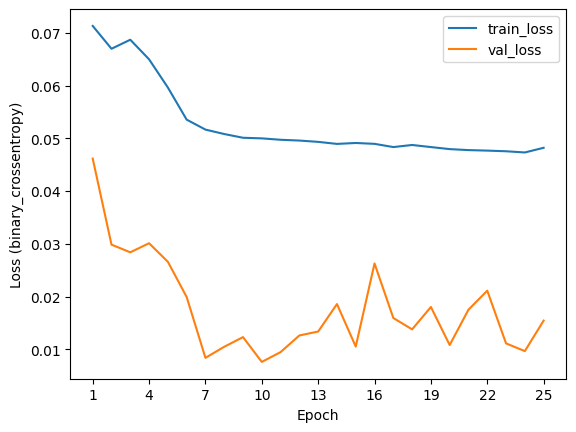

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

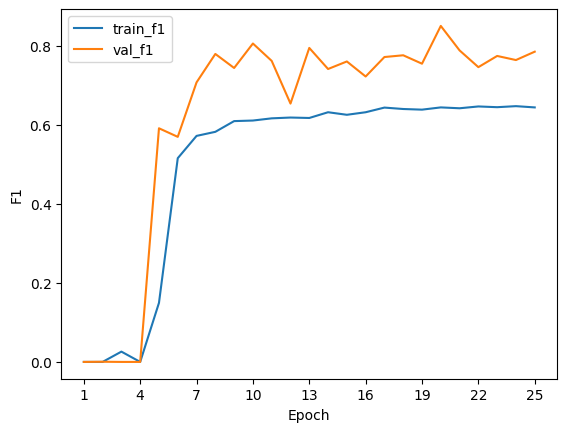

In [ ]:
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))